In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
# from sklearn.compose import TransformedTargetRegressor
# from sklearn.preprocessing import FunctionTransformer

from xgboost import XGBRegressor
from tqdm.auto import tqdm

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
df = pd.read_csv("Final_df_regression.csv", parse_dates=['DATE'])

In [3]:
df.head(3)

,powiat_voivod,DATE,CC,FG,HU,RR,SD,TG,voivodship,[animal stock] total,...,dayofweek,season,CAQI_lag1,holiday_name,is_school_holiday,is_lockdown,is_have_coalplant,rolling7_CAQI,rolling30_CAQI,rolling90_CAQI
0,"powiat aleksandrowski, kujawsko-pomorskie",2017-01-01,4.746750,0.0,88.4,1.0,0.0,1.8,kujawsko-pomorskie,44.997895,...,6,Winter,24.968064,New Year's Day,0.0,0.0,0.0,24.968064,28.884791,47.077522
1,"powiat aleksandrowski, kujawsko-pomorskie",2017-01-02,6.167555,36.8,88.4,1.0,0.0,0.5,kujawsko-pomorskie,44.997895,...,0,Winter,24.968064,Non Holiday,0.0,0.0,0.0,24.968064,28.884791,47.077522
2,"powiat aleksandrowski, kujawsko-pomorskie",2017-01-03,5.198131,0.0,88.4,63.0,0.0,0.3,kujawsko-pomorskie,44.997895,...,1,Winter,17.943745,Non Holiday,0.0,0.0,0.0,21.455904,28.884791,47.077522


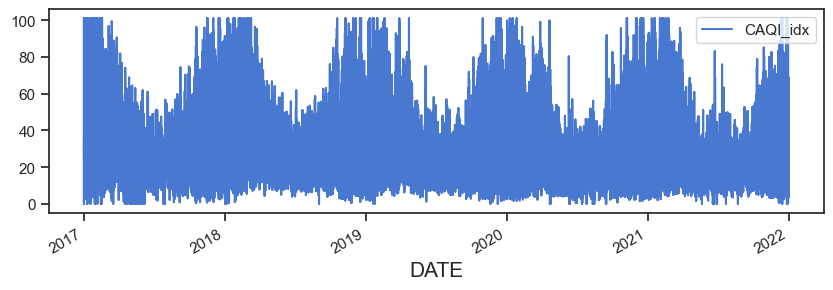

In [4]:
df.plot(x='DATE', y='CAQI_idx', figsize=(10, 3));

In [5]:
df.columns = [col.replace("[", "").replace("]", " -") for col in df.columns]

In [6]:
#Creating weekend col
df["is_weekend"] = np.where(df['dayofweek'].isin([5, 6]), 1, 0)

In [7]:
#For this dataset, better to sort by date and powiat_voivod

# to_drop = ['CAQI_lag1', "is_weekend"]
try:
    df_copy = df.sort_values(['DATE', 'powiat_voivod']).set_index('DATE').\
                  drop(to_drop, axis=1).copy()
except NameError:
    df_copy = df.sort_values(['DATE', 'powiat_voivod']).set_index('DATE').copy()

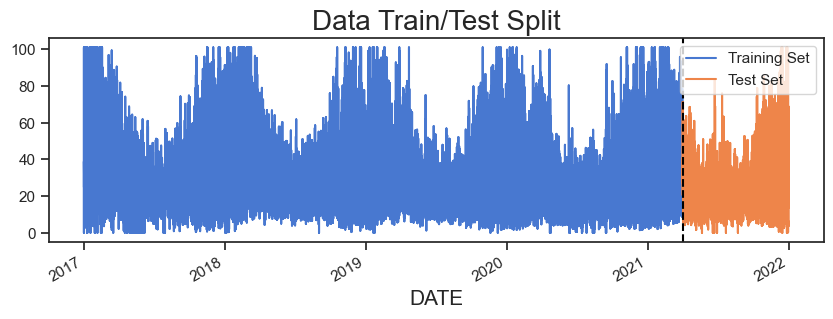

In [8]:
#I will use 8 months of data as test set

cut_off_date = "2021-04-01"

train = df_copy.loc[df_copy.index < cut_off_date]
test = df_copy.loc[df_copy.index >= cut_off_date]

#Visualizing how the data is split
fig, ax = plt.subplots(figsize=(10, 3))

train.plot(y='CAQI_idx', ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(y='CAQI_idx', ax=ax, label='Test Set')

ax.axvline(cut_off_date, color='black', ls='--')

ax.legend(['Training Set', 'Test Set'])
plt.show();

In [9]:
X_train = train.drop('CAQI_idx', axis=1)
y_train = train['CAQI_idx']

X_test = test.drop('CAQI_idx', axis=1)
y_test = test['CAQI_idx']

In [10]:
cat_variables=['powiat_voivod', 'voivodship', 'season', 'holiday_name']
time_variables = ['day', 'month', 'dayofweek']

#Encode categorical columns with numbers.
ord_encoder=OrdinalEncoder(encoding_method='arbitrary', variables=cat_variables)

#Convert time features such as day, month and day of week to cyclical features to maintain cyclicity.
cf_encoder = CyclicalFeatures(variables=time_variables)

#Creating encoder pipeline
encoders = make_pipeline(
    (ord_encoder), #Ordinal Encoder
    (cf_encoder), #Cyclical Feature
)

In [11]:
# XGBoost
xgb=XGBRegressor(
    n_estimators=100,
    max_depth=6,
    eta=0.1,
    gamma=2,
    n_jobs=-1, 
    random_state=seed,
    eval_metric="rmse"
)

#Putting whole pipeline together
pipeline = make_pipeline(
    (encoders), #Encoders
    (xgb) #XGBoost
)

print("Pipeline Created!")

Pipeline Created!


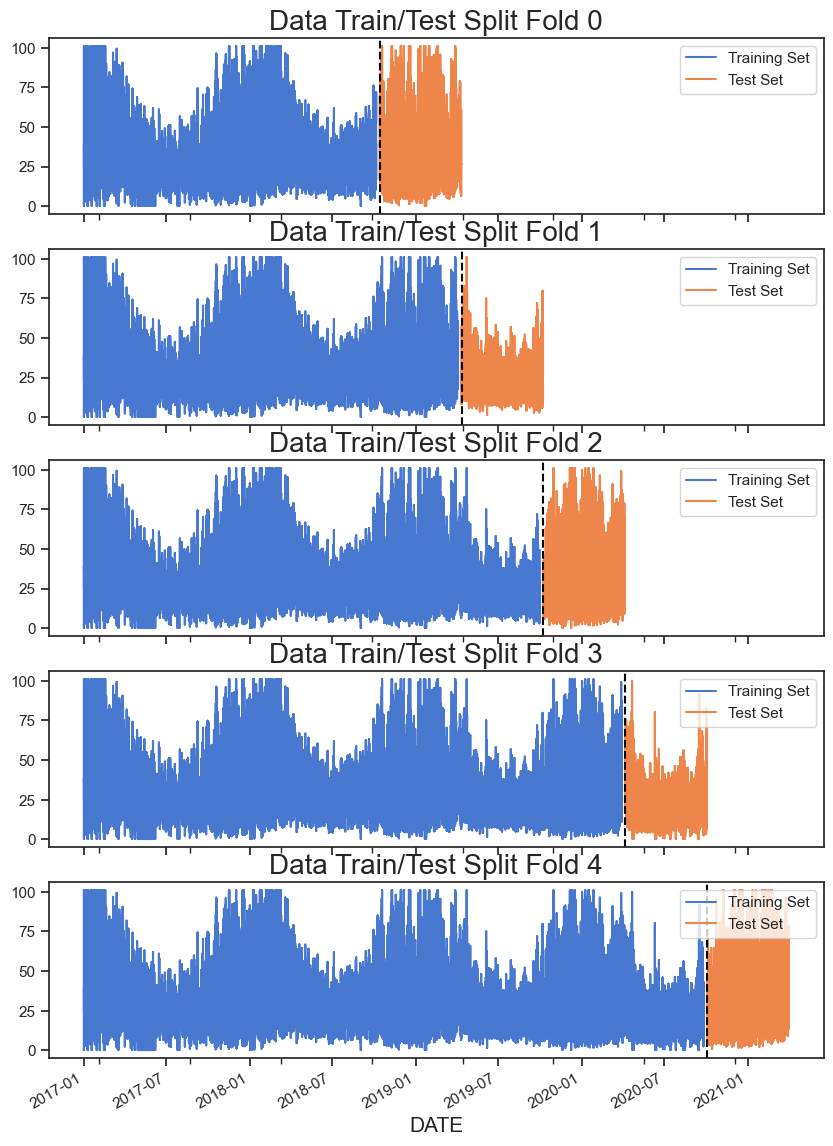

In [12]:
#Visualizing how the cross validation will be done
n_split = 5

max_train_size=None
# max_train_size=198*365

tss = TimeSeriesSplit(n_splits=n_split, max_train_size=max_train_size, test_size=198*180, gap=198*7)

fig, axs = plt.subplots(n_split, 1, figsize=(10, n_split*3), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train):
    train_cv = train.iloc[train_idx]
    test_cv = train.iloc[val_idx]
    
    train_cv.plot(y='CAQI_idx', ax=axs[fold], label='Training Set',
                  title=f'Data Train/Test Split Fold {fold}')
    
    test_cv.plot(y='CAQI_idx', ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--')
    
#     print(len(train_cv.index)/198, len(test_cv.index)/198)
    
    fold += 1

In [13]:
%%time
#Training the pipeline using Cross validation
rmse_values = []

cv = 1
# Loop through the folds
print("Cross Validating.....")
print()

for train_index, test_index in tss.split(X_train, y_train):
       
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model on the train data
    pipeline.fit(X_train_cv, y_train_cv)

    # Predict on the test data
    y_pred = pipeline.predict(X_test_cv)
    
    # Calculate the mean squared error
    rmse = mean_squared_error(y_test_cv, y_pred, squared=False)
        
    print(f"cv #{cv}: RMSE = {rmse:.3f}")
    
    rmse_values.append(rmse)
    cv += 1

# Print the average MSE over all folds
print()
print(f"Average RMSE: {np.mean(rmse_values):.3f}")

Cross Validating.....

cv #1: RMSE = 11.916
cv #2: RMSE = 5.932
cv #3: RMSE = 10.419
cv #4: RMSE = 5.470
cv #5: RMSE = 10.957

Average RMSE: 8.939
Wall time: 5min 57s


In [14]:
feat_scores=pipeline.steps[-1][-1].feature_importances_

#Creating a dataframe for feature importance
feat_imp_df = \
pd.DataFrame({
    'features' :encoders.fit_transform(X_train).columns,
    'importance' : np.round(feat_scores, 3)
}).set_index('features').sort_values('importance')

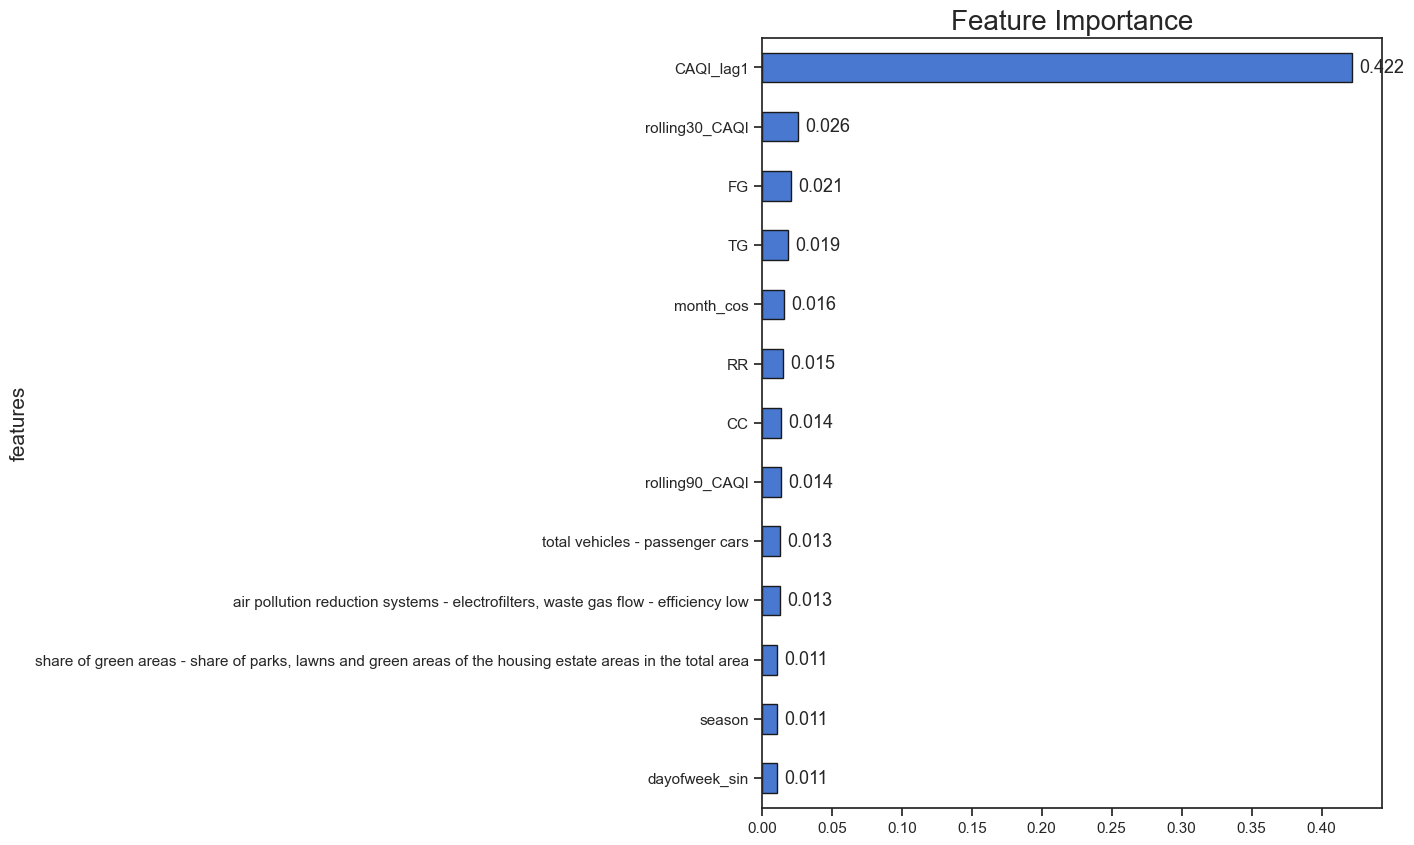

In [15]:
ax = feat_imp_df.query("importance >= 0.01").plot(kind='barh', edgecolor='k', figsize=(8, 10))

ax.bar_label(ax.containers[0], fontsize = 13, padding = 5);
ax.legend().remove()
ax.set_title("Feature Importance");

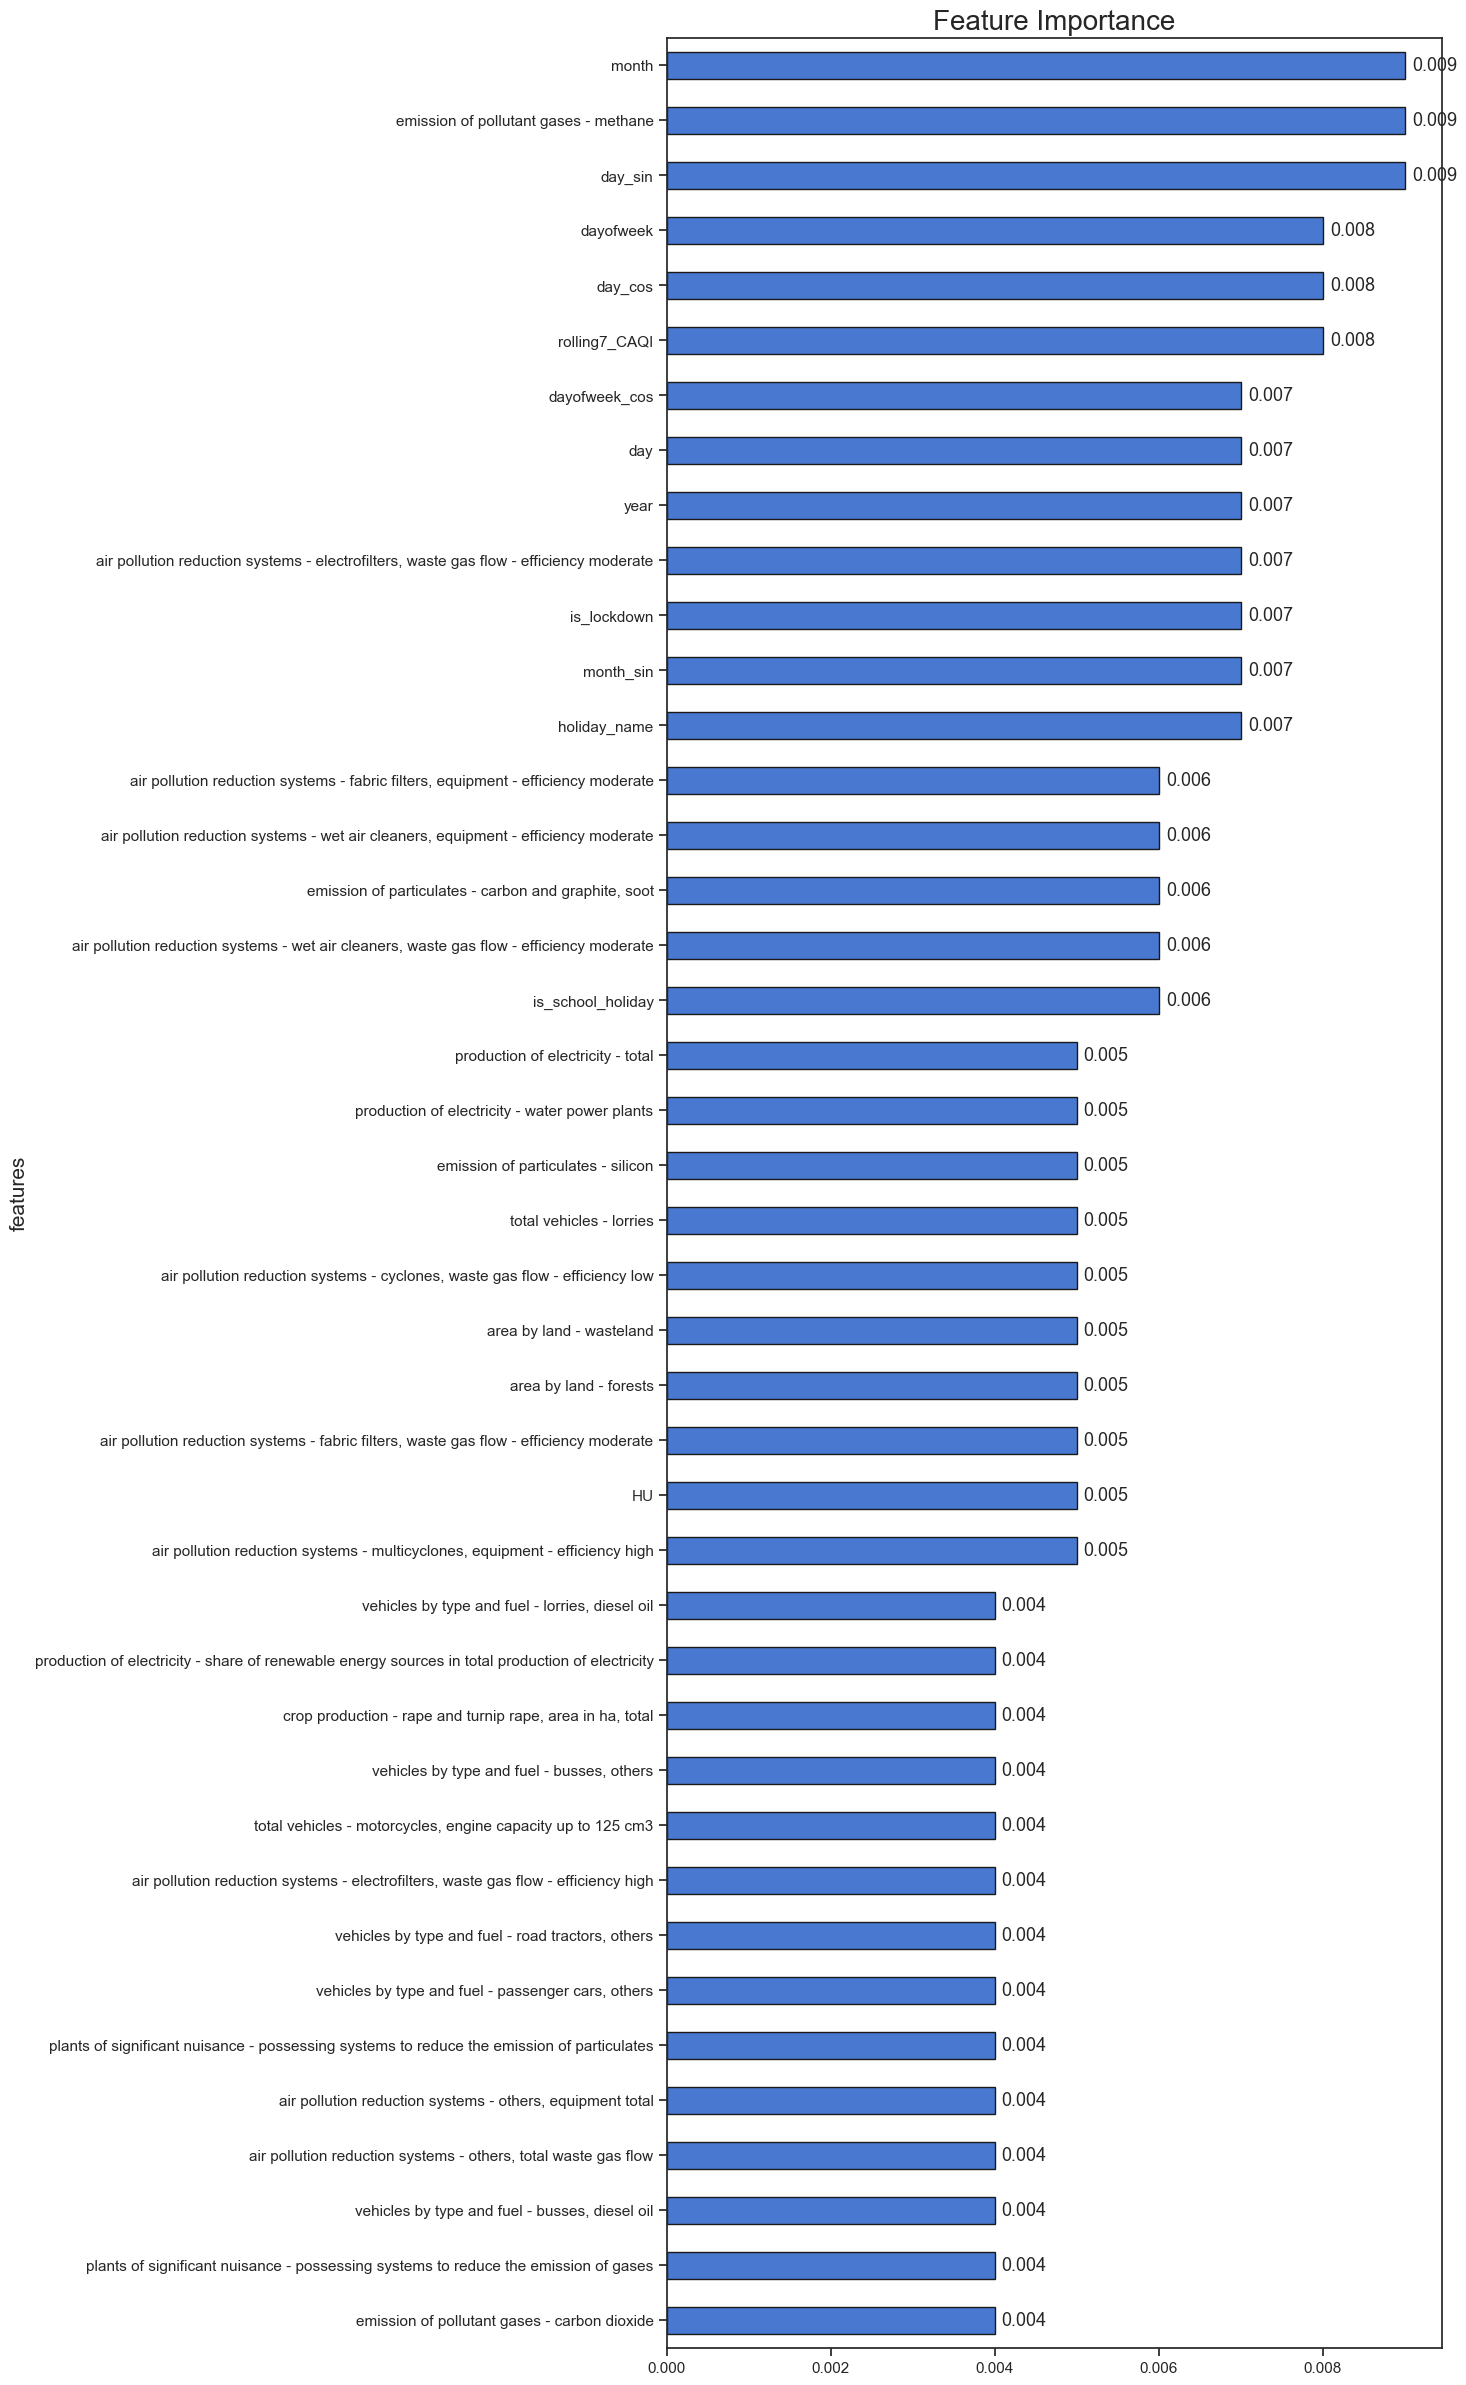

In [16]:
ax = feat_imp_df.query("importance < 0.01 and importance >= 0.004").\
    plot(kind='barh', edgecolor='k', figsize=(10, 30))

ax.bar_label(ax.containers[0], fontsize = 13, padding = 5);
ax.legend().remove()
ax.set_title("Feature Importance");

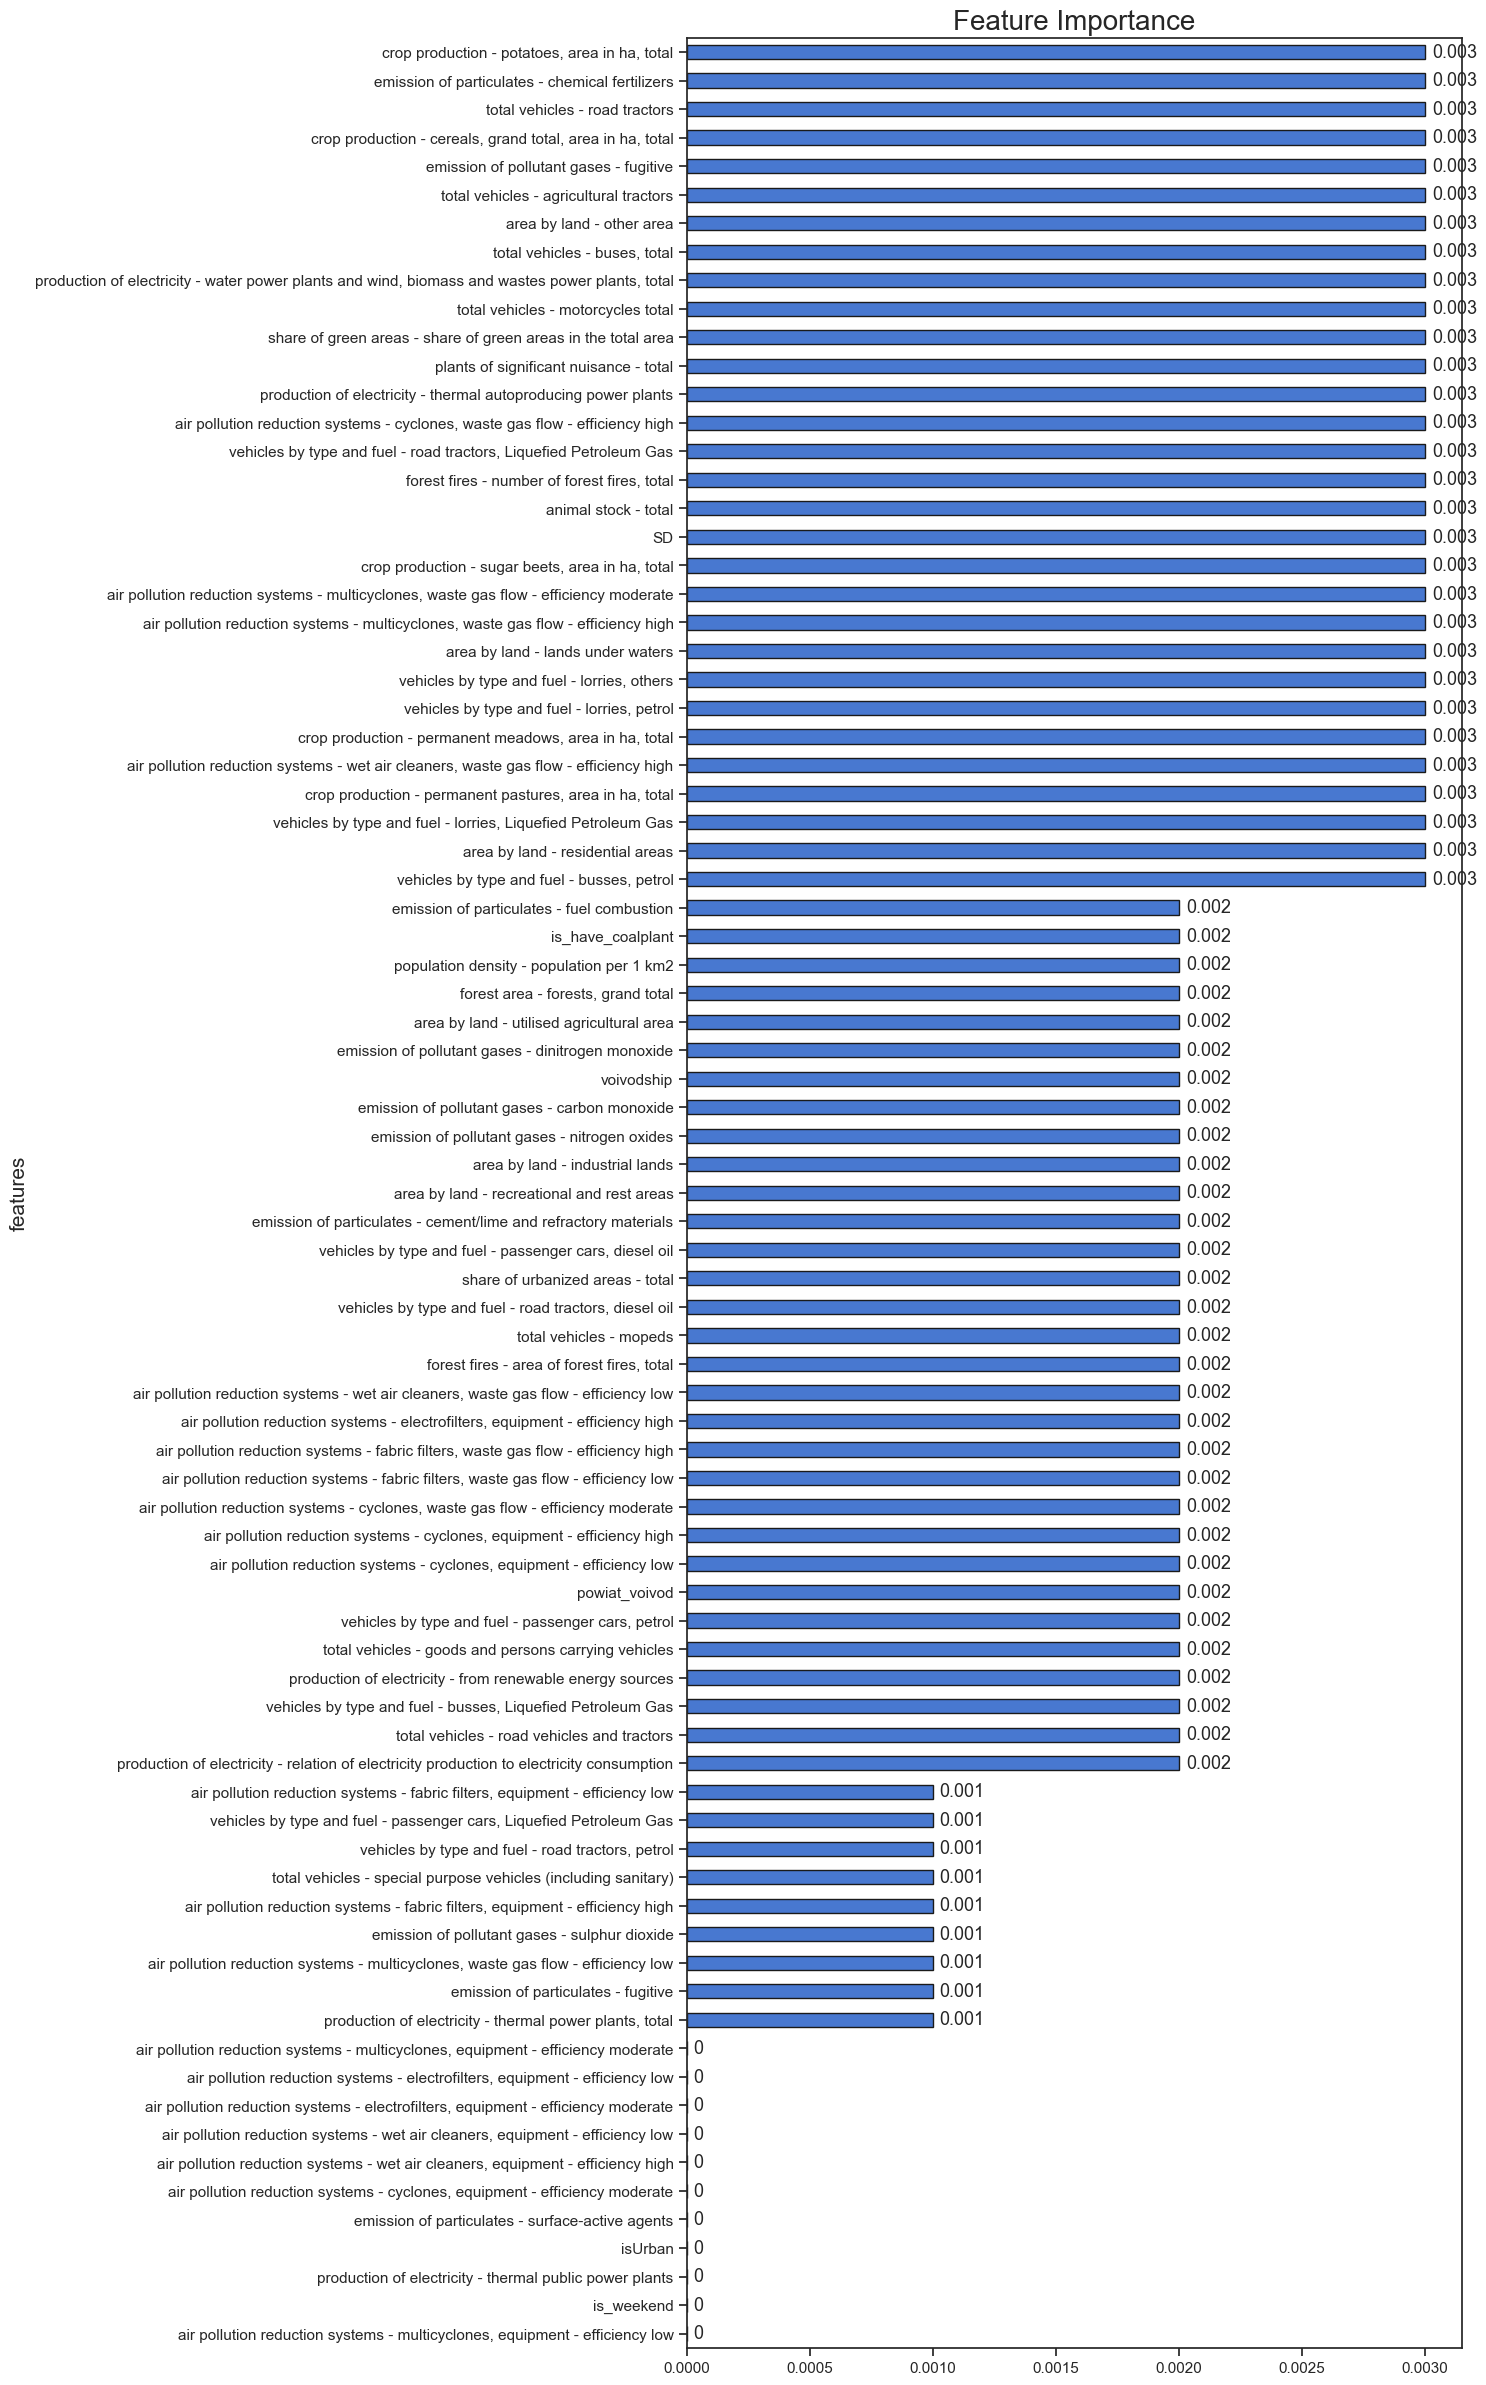

In [17]:
ax = feat_imp_df.query("importance < 0.004").\
    plot(kind='barh', edgecolor='k', figsize=(10, 30))

ax.bar_label(ax.containers[0], fontsize = 13, padding = 5);
ax.legend().remove()
ax.set_title("Feature Importance");

In [18]:
np.sort(feat_imp_df.query("importance==0").index)

array(['air pollution reduction systems - cyclones, equipment - efficiency moderate',
       'air pollution reduction systems - electrofilters, equipment - efficiency low',
       'air pollution reduction systems - electrofilters, equipment - efficiency moderate',
       'air pollution reduction systems - multicyclones, equipment - efficiency low',
       'air pollution reduction systems - multicyclones, equipment - efficiency moderate',
       'air pollution reduction systems - wet air cleaners, equipment - efficiency high',
       'air pollution reduction systems - wet air cleaners, equipment - efficiency low',
       'emission of particulates - surface-active agents', 'isUrban',
       'is_weekend',
       'production of electricity - thermal public power plants'],
      dtype=object)

In [19]:
predictions = pipeline.predict(X_test)

test_rmse = mean_squared_error(y_test, predictions, squared=False)

print(f"Test RMSE Score: {test_rmse:.3f}")

Test RMSE Score: 7.229


In [20]:
test_df = pd.concat([X_test[['powiat_voivod', 'voivodship']], y_test], axis=1)
test_df['predictions'] = predictions

test_df['error'] = test_df['CAQI_idx'] - test_df['predictions']

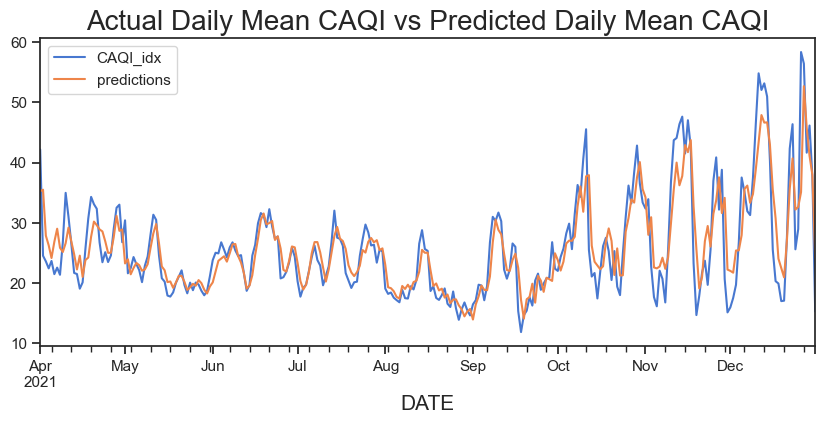

In [21]:
test_df.groupby(test_df.index)[['CAQI_idx', 'predictions']].mean().\
    plot(title='Actual Daily Mean CAQI vs Predicted Daily Mean CAQI', figsize=(10, 4));

In [22]:
# voivod_predict=\
# test_df.groupby(["voivodship", test_df.index])[["CAQI_idx", "predictions"]].mean()

# for v in df['voivodship'].unique():
#     voivod_predict[voivod_predict.index.get_level_values(0)==v].unstack("voivodship").\
#         plot(figsize=(10, 4));